In [ ]:
import torch
from diffusers import DiffusionPipeline, UNet2DConditionModel
from peft import LoraConfig, get_peft_model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/MyDrive/sd15_local"

pipe = DiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
).to("cuda")

unet = pipe.unet
unet.requires_grad_(False)   # Freeze base UNet


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

# LoRA Example Using a 28×28 Image

## 1) Input Image as a Vector

A grayscale MNIST image has size **28 × 28**.

We flatten it into a vector:

x ∈ ℝ⁷⁸⁴

That means the image is now represented as **784 numerical pixel values**.

---
## 2) A Normal Linear Layer (Without LoRA)

Suppose we have a linear layer that maps the image vector into **128 features**:

y = W₀ x

Where:

W₀ ∈ ℝ¹²⁸ˣ⁷⁸⁴

### Number of trainable parameters (Full Fine-Tuning)

128 × 784 = **100,352 parameters**

If we fine-tune normally, we must update **all 100,352 weights**.

---
## 3) Adding LoRA to the Same Layer

So far, we have a normal linear layer with a large weight matrix W₀.  
If we fine-tune this layer in the usual way, we must update **all** its weights — which is expensive in memory and slow for large models.

The goal of **LoRA (Low-Rank Adaptation)** is to solve this problem:

> **How can we adapt a large pretrained model to a new task, without updating all its weights?**

Instead of modifying W₀ directly, LoRA keeps W₀ **frozen** and adds a small trainable update on top of it.  
This lets us change the model’s behavior with only a tiny number of new parameters.

Mathematically, LoRA adds a low-rank update to the original weight matrix:
W = W₀ + BA

LoRA modifies the layer as:

- y = (W₀ + BA)
- x = W₀x + B(Ax)

We keep W₀ **frozen**, and only train A and B.

We choose a small rank:

r = 4

So:

A ∈ ℝ⁴ˣ⁷⁸⁴
B ∈ ℝ¹²⁸ˣ⁴

## 3.0) What do A and B represent?

LoRA does not change the original weight matrix W₀.  
Instead, it adds a **low-rank adaptation**:

ΔW = BA

### A — The Compressor

• Takes the high-dimensional input (784 features)  
• Compresses it into a small space of size r (rank)  
• Learns **which input directions are important to adjust**

### B — The Expander

• Takes the small r-dimensional vector  
• Expands it back to 128 output features  
• Learns **how to apply the adjustment to the output**

### Together

Ax → Compression  
B(Ax) → Re-expansion  

So the final layer becomes:

y = W₀x + B(Ax)

• W₀x keeps the original model knowledge  
• B(Ax) adds a small learned change


## 3.1) How do A and B learn?

A and B are new trainable weight matrices.  
They are initialized randomly at the start of fine-tuning.

During training:

1) We pass data through the layer  
2) Compute the loss  
3) Run backpropagation

Key rule:

• W₀ is frozen (no updates)  
• Only A and B receive gradients

So the optimizer updates:

A ← A − η ∇A  
B ← B − η ∇B

While W₀ remains unchanged.

After training:

• A learns **what to change**  
• B learns **how to apply the change**

---
## 4) Trainable Parameters with LoRA

Number of parameters to train:

- A: 4 × 784 = 3,136

- B: 128 × 4 = 512

Total = **3,648 parameters**

---
## 5) Parameter Savings

| Method | Trainable Parameters |
|--------|----------------------|
| Full Fine-Tuning | 100,352 |
| LoRA (r = 4) | 3,648 |

LoRA trains **~27× fewer parameters** in this single layer.

---
## 6) What Happens During Forward Pass

Instead of computing only:

y = W₀x

We compute:

y = W₀x + B(Ax)

• W₀x keeps the original knowledge
• B(Ax) adds a small learned adjustment

This small adjustment is enough to change the model’s behavior toward a new style or task.

---
## 7) Key Takeaway

**LoRA allows us to adapt a large model by training only a tiny number of additional parameters, while keeping the original model fully intact.**

In [ ]:
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["to_q","to_k","to_v","to_out.0"],
    lora_dropout=0.1,
    bias="none"
)

unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()


trainable params: 797,184 || all params: 860,318,148 || trainable%: 0.0927


## 8) Where do we insert LoRA inside Stable Diffusion?

Stable Diffusion is a large model, but the **core component that controls image generation** is the **UNet**.

Inside the UNet, the most important part is the **Attention Layers**.
These layers decide **how the text prompt influences the image features**.

So, if we want to change the model’s style or behavior,
the smartest place to adapt is **the attention mechanism** — not the whole network.

---

### Why Attention Layers?

During generation:

• The text prompt is converted into text embeddings
• The UNet processes noisy image latents
• **Cross-Attention layers connect text and image**

This means attention layers answer the question:

> “Which words in the prompt should influence which parts of the image?”

So, modifying attention layers = modifying **how the model understands and applies text guidance**.

---

### Which parts of Attention do we target?

Each attention layer contains four key projection matrices:

• **to_q** → creates Query vectors
• **to_k** → creates Key vectors
• **to_v** → creates Value vectors
• **to_out** → projects attention output back to the network

These matrices control **how information flows inside attention**.

Therefore, in LoRA we insert adapters into:

```
to_q, to_k, to_v, to_out
```

---

### Why not modify everything?

Because:

• UNet has hundreds of millions of parameters
• Most knowledge (shapes, objects, composition) is already correct
• We only want to **slightly adjust behavior or style**

LoRA adds small low-rank updates **only inside attention**,
giving maximum effect with minimal new parameters.

---

### A simple example

Prompt:

> "A handwritten word on a white background"

Before LoRA (Base Model):

• The attention layers focus on the word *"handwritten"*
• The model produces **generic handwriting style**

After LoRA trained on MNIST:

• LoRA slightly changes the attention projections
• The model now focuses more on **digit-like strokes**
• The output becomes **MNIST-style handwriting**

So, LoRA did not change the whole UNet —
It only changed **how attention connects text to image features**.

---
> **LoRA is inserted into the attention projection layers of the UNet, because attention is where text controls image generation.**


In [ ]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),  # <-- add this RGP وهمي
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)


In [ ]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)
vae = pipe.vae
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
scheduler = pipe.scheduler

unet.train()


## The Core Idea — What Are We Really Teaching?

In this project, our objective is **not** to teach the model:
- What each digit means (0, 1, 2, …)
- Or how to recognize numbers linguistically

Instead, our objective is:

> **To teach the model the MNIST handwriting style.**

All MNIST images share the same visual identity:
- Stroke thickness
- Curve shapes
- Writing consistency

So we only need **one shared textual identity** to represent this style.

---

## Why Not Use "zero", "one", "two", ... ?

If we used different prompts per image:

```
"zero", "one", "two", ...
```

The model would need to learn:
- The shape of each digit
- The meaning of each word
- The mapping between word and image

That means:
- More complexity
- Longer training
- Larger model capacity

But this is **not our goal**.

---

## Why Using One Prompt Works

By assigning the same prompt:

```
"digit"
```

to **all** images, we tell the model:

> “Everything paired with the word *digit* represents one visual style.”

So the model learns:
- A single text embedding for "digit"
- Strong association with MNIST handwriting style
- No concern about number identity

This is exactly what we want.

---

## How CLIP is Used in the Code

These two lines represent **CLIP**

```python
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
```

### ✅ `pipe.tokenizer`
This is the **CLIP Tokenizer**  
It converts the text prompt into tokens (numbers).

### ✅ `pipe.text_encoder`
This is the **CLIP Text Encoder**  
It converts tokens into **Text Embeddings** (numerical meaning vectors).

Together, they form the **CLIP Text Model**.


During training, every image batch is paired with the **same text prompt**:

```
"digit"
```
## CLIP Tokenization and Text Embedding

```python
tokens = tokenizer(
    ["digit"] * images.size(0),   # Repeat "digit" for the whole batch
    padding="max_length",
    max_length=77,
    return_tensors="pt"
).input_ids.to("cuda")

text_emb = text_encoder(tokens)[0]
```

CLIP converts this text into a numerical embedding.
This embedding becomes the **style condition** for the diffusion model.

---

## What Happens Here? (Step-by-Step)

1. `["digit"] * images.size(0)`  
   Every image in the batch receives the same prompt.

2. `tokenizer(...)`  
   Converts the word "digit" into CLIP tokens.

3. `text_encoder(tokens)`  
   Produces a high-dimensional text embedding.

4. `text_emb`  
   Represents **the MNIST handwriting style** in vector form.

This embedding is later injected into the diffusion U-Net through cross-attention.

---

In [ ]:

for step, (images, labels) in enumerate(train_loader):
    if step > 500: break   # تدريب سريع للتجربة

    images = images.to("cuda", dtype=torch.float16)

    # Encode images to latent space
    latents = vae.encode(images).latent_dist.sample() * 0.18215

    # Dummy text prompt
    tokens = tokenizer(["digit"] * images.size(0), # [B,C,W,H]
                        padding="max_length",
                        max_length=77,
                        return_tensors="pt").input_ids.to("cuda")

    text_emb = text_encoder(tokens)[0]

    # Add noise
    noise = torch.randn_like(latents) # 1 unet
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.size(0),), device="cuda").long()
    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    # Predict noise
    noise_pred = unet(noisy_latents, timesteps, text_emb).sample

    loss = F.mse_loss(noise_pred, noise)

    optimizer.zero_grad()
    loss.backward() # lora, update AB only ,   w = wold(frezze) + AB
    optimizer.step()

    if step % 50 == 0:
        print("Step:", step, "Loss:", loss.item())


Step: 0 Loss: 0.022369384765625
Step: 50 Loss: 0.006351470947265625
Step: 100 Loss: 0.00917816162109375
Step: 150 Loss: 0.044769287109375
Step: 200 Loss: 0.0599365234375
Step: 250 Loss: 0.0213165283203125
Step: 300 Loss: 0.06561279296875
Step: 350 Loss: 0.014801025390625
Step: 400 Loss: 0.003265380859375
Step: 450 Loss: 0.00348663330078125
Step: 500 Loss: 0.023773193359375


In [ ]:
# Path where LoRA will be saved
save_path = "/content/drive/MyDrive/mnist_sd_lora"

# Save unet = LoRA adapter
unet.save_pretrained(save_path)

print("✅ LoRA Saved to Google Drive!")
print("📂 Location:", save_path)


Mounted at /content/drive
✅ LoRA Saved to Google Drive!
📂 Location: /content/drive/MyDrive/mnist_sd_lora


In [ ]:
# ============================================
# 2: Load Stable Diffusion + Attach LoRA
# ============================================

import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel

model_path = "/content/drive/MyDrive/sd15_local"

# Load base Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
).to("cuda")

# Path to LoRA on Google Drive
lora_path = "/content/drive/MyDrive/mnist_sd_lora"

# Attach LoRA to UNet
pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)

print("✅ LoRA Loaded from Google Drive!")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


✅ LoRA Loaded from Google Drive!


In [ ]:
# ============================================
# 3: Load Base Stable Diffusion (No LoRA)
# ============================================

pipe_base = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
).to("cuda")

print("✅ Base Stable Diffusion Loaded!")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Base Stable Diffusion Loaded!


In [ ]:
# ============================================
# Cell 4: Define Prompt
# ============================================

prompt = """
A simple hand-drawn sketch of a cat inside a classroom, black ink on white background, minimal line art, MNIST handwriting style
"""

  0%|          | 0/100 [00:00<?, ?it/s]

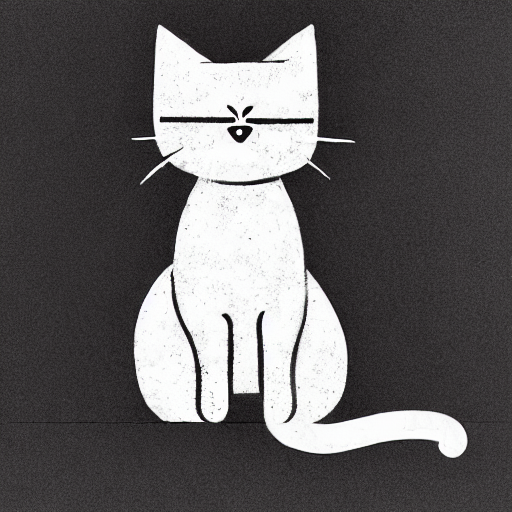

In [ ]:
# ============================================
# 5: Inference with Stable Diffusion + LoRA
# ============================================

image_lora = pipe(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=torch.manual_seed(500)
).images[0]

image_lora


  0%|          | 0/100 [00:00<?, ?it/s]

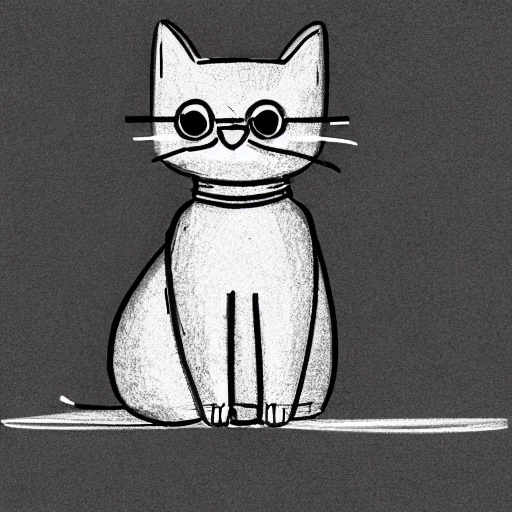

In [ ]:
# ============================================
#  6: Inference with Base Stable Diffusion
# ============================================

image_base = pipe_base(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=torch.manual_seed(500)
).images[0]

image_base


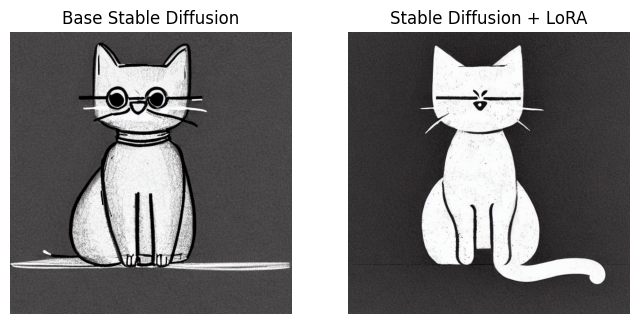

In [ ]:
# ============================================
#  7: Visual Comparison
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(image_base)
plt.title("Base Stable Diffusion")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image_lora)
plt.title("Stable Diffusion + LoRA")
plt.axis("off")

plt.show()


| Aspect | Base Stable Diffusion | Stable Diffusion + LoRA |
|--------|----------------------|--------------------------|
| Writing style | Generic handwriting | MNIST-like handwriting |
| Stroke thickness | Smooth / thin strokes | Thicker, marker-like strokes |
| Digit clarity | Weak / unclear digit form | Clearer digit-like structure |
| Training effect | No adaptation | Visible LoRA adaptation |
